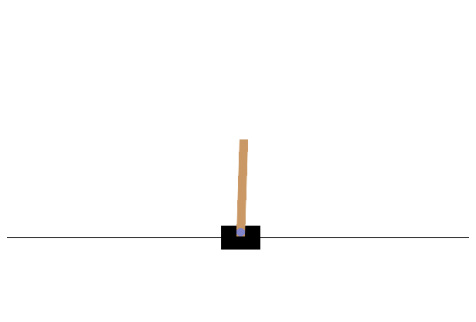

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation

# Create environment with rgb_array render mode
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Reset environment
observation, info = env.reset(seed=42)

# For storing frames
frames = []

# Run the environment
for _ in range(200):
    # Render
    frame = env.render()
    frames.append(frame)
    
    # Take random action
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    
    if terminated or truncated:
        break

env.close()

# Create animation
fig = plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])
    return [patch]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50, blit=True)
plt.show()
# To save: anim.save('cartpole.mp4', fps=30)